In [184]:
import torch
import matplotlib.pyplot as plt

In [195]:
fs = 100
time = torch.linspace(0, 3, fs * 3)

def gen_sin(freq, phi = 0.0):
    return torch.sin(2 * torch.pi * freq * time + phi)

sig_f1 = gen_sin(1)
sig_f2 = gen_sin(2, torch.pi / 2)
sig_f3 = gen_sin(3)
sig_f6_5 = gen_sin(6.5)

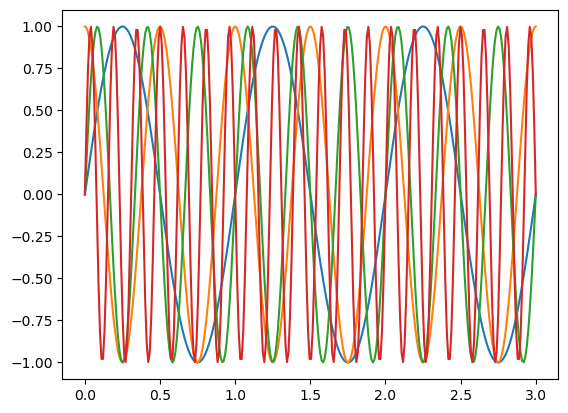

In [196]:
plt.plot(time, sig_f1)
plt.plot(time, sig_f2)
plt.plot(time, sig_f3)
plt.plot(time, sig_f6_5)
plt.show()

torch.Size([300, 2])


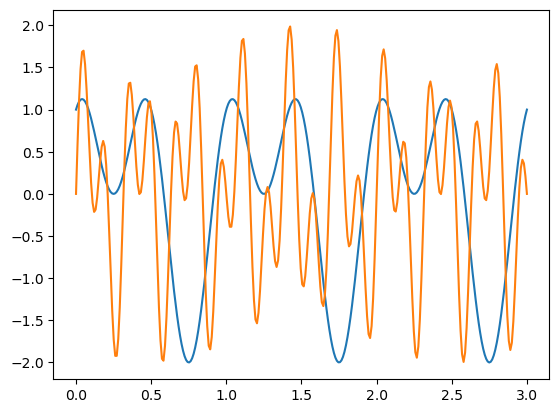

In [207]:
sig_sum_1 = sig_f1 + sig_f2
sig_sum_2 = sig_f3 + sig_f6_5
sig_sum = torch.stack((sig_sum_1, sig_sum_2)).T
print(sig_sum.shape)
plt.plot(time, sig_sum)

In [199]:
sig_fft = torch.fft.fft(sig_sum, dim=1)
sig_fft[:5]

tensor([ 5.8122+0.0000j,  5.8579-0.4239j,  6.0152-1.2960j,
        10.9691-149.8264j,  6.7551+1.4695j])

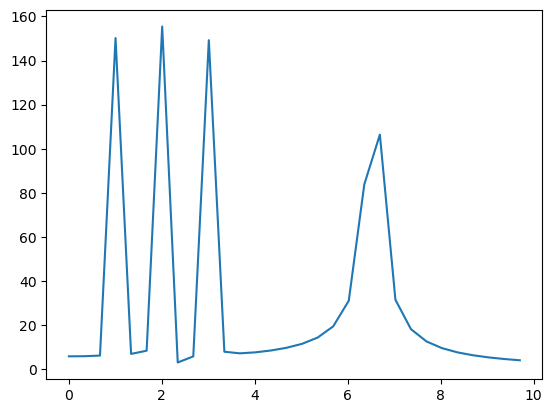

In [200]:
fft_mag = torch.abs(sig_fft)
freq = torch.linspace(0, fs, len(fft_mag))
plot_len = int(len(fft_mag) / (fs)) * 10
plt.plot(freq[:plot_len], fft_mag[:plot_len])

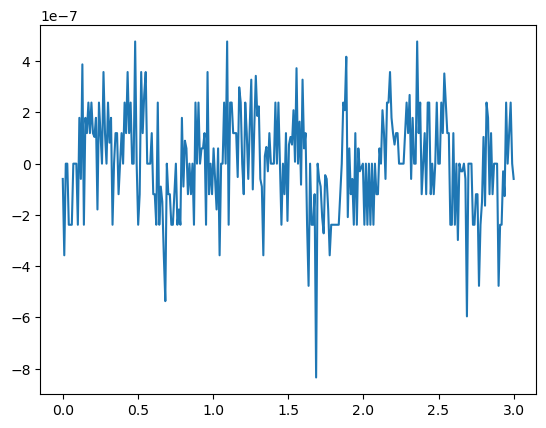

In [201]:
sig_restored = torch.fft.ifft(sig_fft)
plt.plot(time, torch.real(sig_restored) - sig_sum)

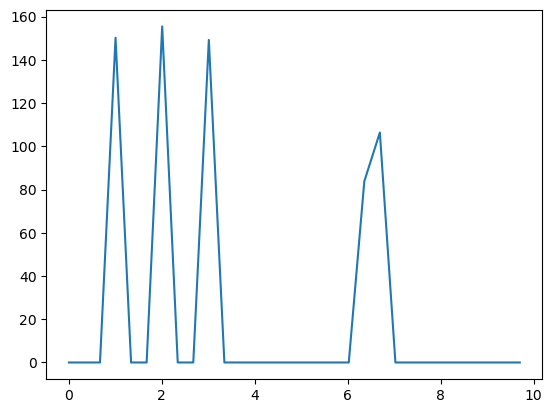

In [202]:
sig_fft[fft_mag < 50] = 0.0
fft_mag = torch.abs(sig_fft)
plt.plot(freq[:plot_len], fft_mag[:plot_len])

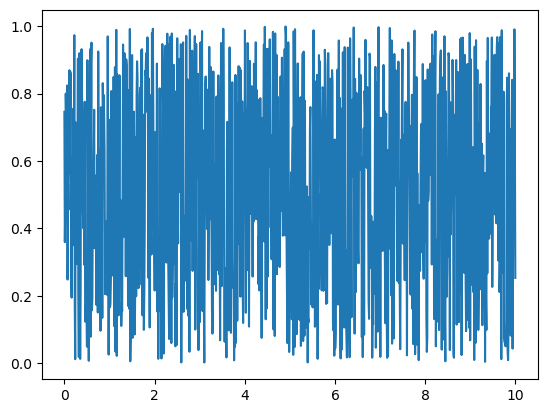

In [192]:
sig_cleared = torch.fft.ifft(sig_fft)
plt.plot(time, torch.real(sig_restored))

c:\Users\19ak9\miniconda3\envs\.idp\lib\site-packages\torch\_tensor.py:958: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


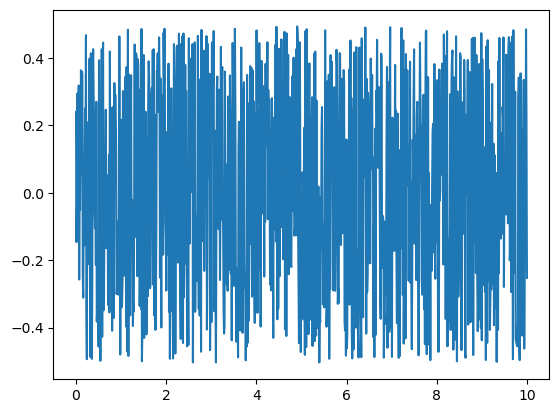

In [193]:
sig_resid = sig_sum - sig_cleared
plt.plot(time, sig_resid)

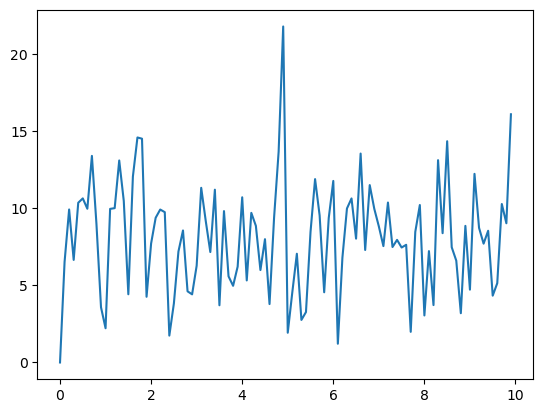

In [194]:
sig_resid_fft = torch.abs(torch.fft.fft(sig_resid))
plt.plot(freq[:plot_len], sig_resid_fft[:plot_len])